In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense,Flatten,BatchNormalization,Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_path = '/content/drive/My Drive/Colab Notebooks/dataset/train'
valid_path = '/content/drive/My Drive/Colab Notebooks/dataset/val'
test_path = '/content/drive/My Drive/Colab Notebooks/dataset/test'

In [ ]:
from tensorflow.keras.applications.resnet import preprocess_input

# Replace VGG16 preprocessing with ResNet preprocessing
train_batches = ImageDataGenerator(preprocessing_function=preprocess_input)\
                .flow_from_directory(directory=train_path, target_size=(224,224), classes=['Capybara','Cat','dog'], batch_size=10)

valid_batches = ImageDataGenerator(preprocessing_function=preprocess_input)\
                .flow_from_directory(directory=valid_path, target_size=(224,224), classes=['Capybara','Cat','dog'], batch_size=10)

test_batches = ImageDataGenerator(preprocessing_function=preprocess_input)\
                .flow_from_directory(directory=test_path, target_size=(224,224), classes=['Capybara','Cat','dog'], batch_size=10, shuffle=False)


Found 10000 images belonging to 3 classes.
Found 10000 images belonging to 3 classes.
Found 10000 images belonging to 3 classes.


In [ ]:
assert train_batches.n == 10000
assert valid_batches.n == 10000
assert test_batches.n == 10000
assert train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes == 3

In [ ]:
imgs , labels = next(train_batches)

In [ ]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize = (20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr,axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

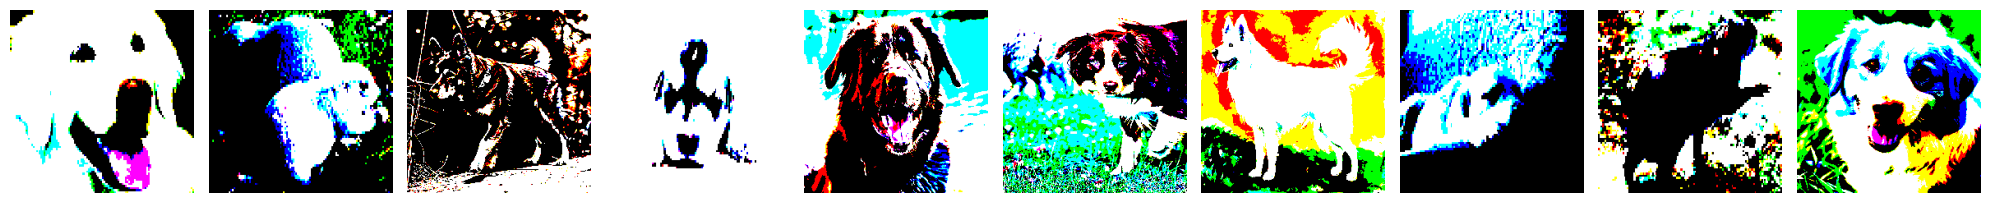

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


In [ ]:
plotImages(imgs)
print(labels)

In [ ]:
from tensorflow.keras.layers import Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense

resnet_model = Sequential()

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                    input_shape=(180, 180, 3),
                    pooling='avg', classes=3,
                    weights='imagenet')

for layer in pretrained_model.layers:
    layer.trainable=True

resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(3, activation='softmax'))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
resnet_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 2048)                │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │           1,539 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,638,339 (93.99 MB)

 Trainable params: 24,585,219 (93.79 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define a single datagen for both training and validation
# We will reserve 33% of the training data for validation
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Create batches with target size 180x180 to match the resnet input size
train_batches = train_datagen.flow_from_directory(
    '/content/drive/My Drive/Colab Notebooks/dataset/train',
    target_size=(180, 180),
    batch_size=32,
    class_mode='categorical',
    subset='training'  # Specify training subset
)

valid_batches = train_datagen.flow_from_directory(
    '/content/drive/My Drive/Colab Notebooks/dataset/train', # Same directory as training
    target_size=(180, 180),
    batch_size=32,
    class_mode='categorical',
    subset='validation' # Specify validation subset
)

Found 8000 images belonging to 3 classes.
Found 2000 images belonging to 3 classes.


In [ ]:
train_batches = train_datagen.flow_from_directory(
    '/content/drive/My Drive/Colab Notebooks/dataset/train',
    target_size=(180, 180), #original code
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

Found 8000 images belonging to 3 classes.


In [ ]:
pretrained_model = tf.keras.applications.ResNet50(include_top=False,
                    input_shape=(180, 180, 3),
                    pooling='avg', classes=3,
                    weights='imagenet')

In [ ]:
resnet_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

epochs = 50
history = resnet_model.fit(
    train_batches,
    validation_data=valid_batches,
    epochs=epochs
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2436s 9s/step - accuracy: 0.8841 - loss: 0.4517 - val_accuracy: 0.3000 - val_loss: 3.7110
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 80s 318ms/step - accuracy: 0.9950 - loss: 0.0176 - val_accuracy: 0.3000 - val_loss: 4.3673
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 80s 319ms/step - accuracy: 0.9898 - loss: 0.0321 - val_accuracy: 0.3180 - val_loss: 3.9228
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 85s 341ms/step - accuracy: 0.9979 - loss: 0.0058 - val_accuracy: 0.6845 - val_loss: 1.6357
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 80s 319ms/step - accuracy: 0.9909 - loss: 0.0358 - val_accuracy: 0.5000 - val_loss: 830.9200
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 86s 342ms/step - accuracy: 0.9936 - loss: 0.0219 - val_accuracy: 1.0000 - val_loss: 2.1851e-05
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 86s 341ms/step - accuracy: 1.0000 - loss: 4.4585e-05 - val_accuracy: 1.0000 - val_loss: 6.0887e-06
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 79s 317ms/step - accuracy: 1.0

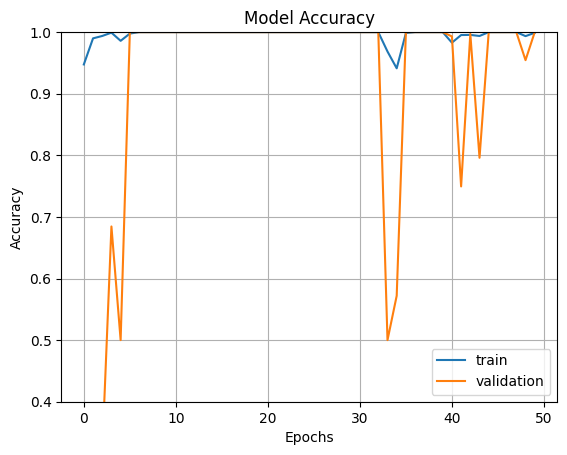

In [ ]:
fig1=plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

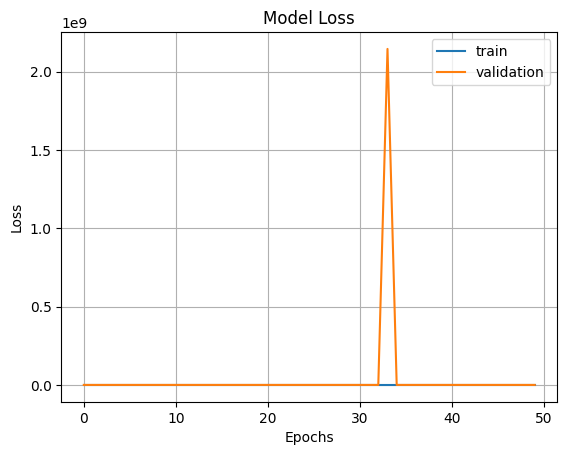

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

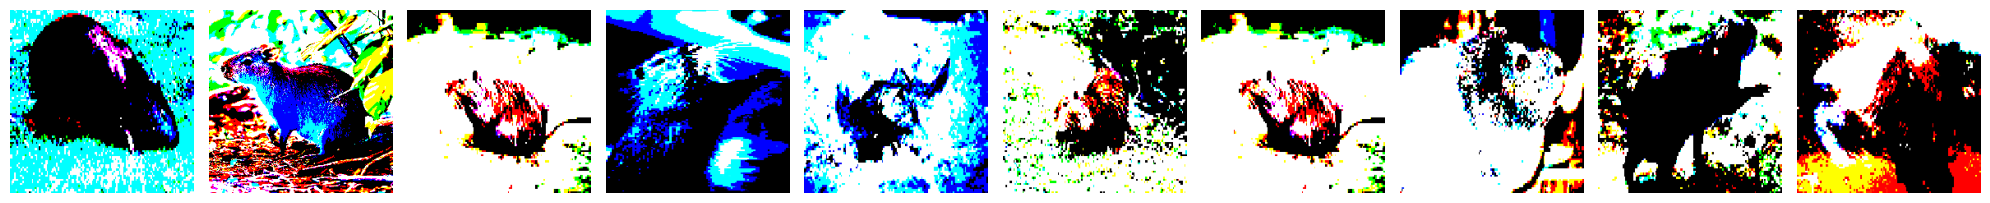

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


In [ ]:
test_imgs, test_labels = next(test_batches)
plotImages(test_imgs)
print(test_labels)

In [ ]:
test_batches.classes

array([0, 0, 0, ..., 2, 2, 2], dtype=int32)

In [ ]:
predictions = resnet_model.predict(x=test_batches, verbose=0)

ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "resnet50" is incompatible with the layer: expected shape=(None, 180, 180, 3), found shape=(10, 224, 224, 3)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(10, 224, 224, 3), dtype=float32)
  • training=False
  • mask=None

In [ ]:
# Ensure that the target_size for test_batches matches the model's input shape
test_batches = ImageDataGenerator(preprocessing_function=preprocess_input)\
                .flow_from_directory(directory=test_path, target_size=(180,180), classes=['Capybara','Cat','dog'], batch_size=10, shuffle=False)

# Now, you can make predictions:
predictions = resnet_model.predict(x=test_batches, verbose=0)

Found 10000 images belonging to 3 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


In [ ]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis = -1))

In [ ]:
def plot_confusion_matrix(cm,classes,
                         normalize = False, title = 'Confusion Matrix',
                         cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks,classes)

    if normalize:
        cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    thresh = cm.max()/2.
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j,i, cm[i,j],
                horizontalalignment='center',
                color='white' if cm[i,j] > thresh else 'black')
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
test_batches.class_indices

{'Capybara': 0, 'Cat': 1, 'dog': 2}

Confusion matrix, without normalization
[[   0    0 3000]
 [   0    0 2000]
 [   0    0 5000]]


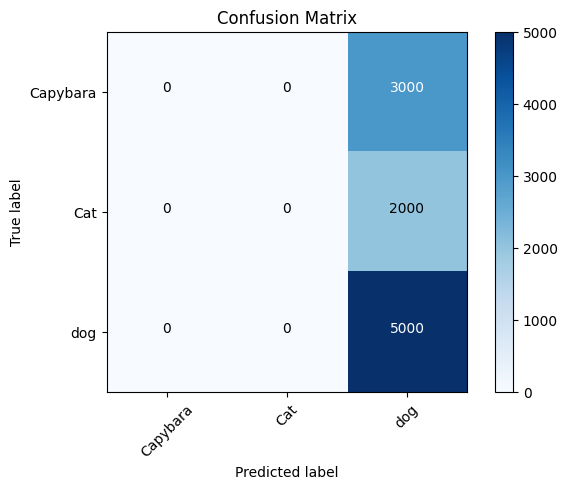

In [ ]:
cm_plot_labels = ['Capybara','Cat','dog']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')
